### Color Matching
This notebook explores matching two puzzle pieces using the colors along the intersecting curve. After finding a set of anchoring points, We switch back to bitmap domain and try to align the two curves according to their colors.

In [3]:
import cv2
from matplotlib import pyplot
from matplotlib.patches import ConnectionPatch
import numpy as np
import os

import piece
import match
import math_utils

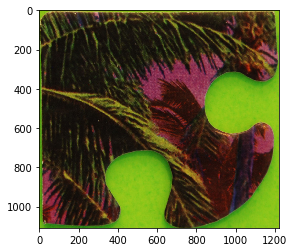

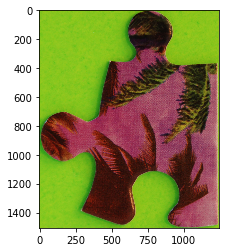

In [81]:
DATA_DIR = '../data/unicorn/'
p1 = piece.read_piece(os.path.join(DATA_DIR, '61.jpg'))
p2 = piece.read_piece(os.path.join(DATA_DIR, '44.jpg'))
pyplot.figure()
pyplot.imshow(p1.image[:, :, [2, 1, 0]])
pyplot.figure()
pyplot.imshow(p2.image[:, :, [2, 1, 0]])

Anchoring points are: (1160, 574) and (1167, 357) at indices (4534, 5358)
Anchoring points are: (912, 363) and (645, 316) at indices (543, 1428)


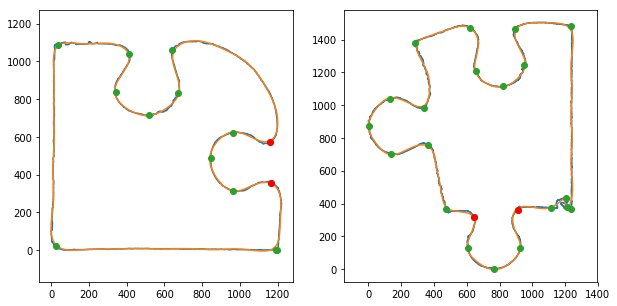

In [15]:
def get_anchor_points(c, cutoff=None, threshold=6e-3, plot=False):
    kwargs = {}
    if cutoff:
        kwargs['cutoff'] = cutoff
    cs = match._smooth_contour(c, cutoff=3.5e-3)
    k = math_utils.curvature(cs)
    cr = math_utils.zero_crossings(np.gradient(k))
    cr = cr[np.abs(k[cr]) > threshold]
    if plot:
        pyplot.plot(c[:, 0], c[:, 1])
        pyplot.plot(cs[:, 0], cs[:, 1])
        pyplot.plot(c[cr, 0], c[cr, 1], 'o')
    return cr

pyplot.figure(figsize=(10, 5))
selection = ((8, 12), (3, 7))
for i, contour, select in zip((1, 2), (p1.contour, p2.contour), selection):
    pyplot.subplot(1, 2, i)
    cr = get_anchor_points(contour, plot=True)
    cr = np.array([cr[select[0]], cr[select[1]]])
    print('Anchoring points are: ({x1}, {y1}) and ({x2}, {y2}) at indices ({i1}, {i2})'.format(
        x1=contour[cr[0], 0],
        y1=contour[cr[0], 1],
        x2=contour[cr[1], 0],
        y2=contour[cr[1], 1],
        i1=cr[0],
        i2=cr[1]))
    pyplot.plot(contour[cr, 0], contour[cr, 1], 'ro')
    pyplot.axis('equal')
pyplot.show()

(388.2, 1263.8, -27.35, 574.35)

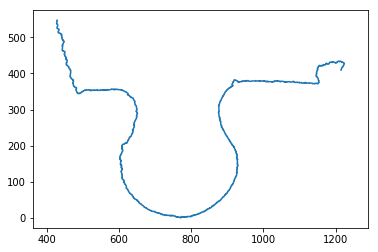

In [38]:
a1 = np.array([4524, 5258])
a2 = np.array([543, 1428])
margin = 400
c1 = p1.contour[a1[0] - margin:a1[1] + margin, :]
c2 = p2.contour[a2[0] - margin:a2[1] + margin, :]

# pyplot.plot(c1[:, 0], c1[:, 1])
pyplot.plot(c2[:, 0], c2[:, 1])
pyplot.axis('equal')

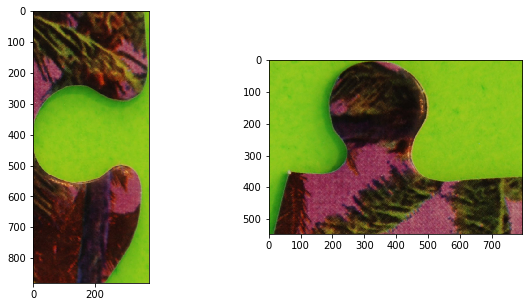

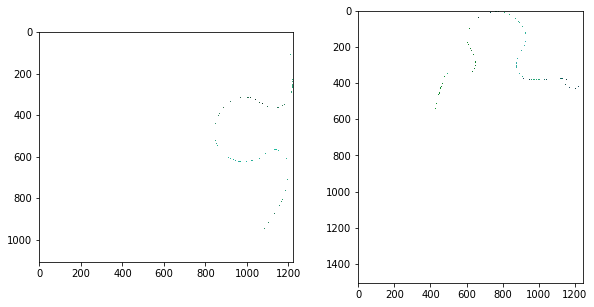

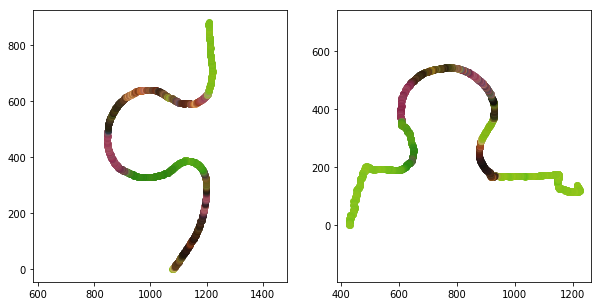

In [211]:
# color patches along the contour
def to_plot_color(rgb):
    return rgb / 256.

pyplot.figure(figsize=(10, 5))
for (i, p, c) in ((1, p1, c1), (2, p2, c2)):
    pyplot.subplot(1, 2, i)    
    xmin, ymin = np.min(c, axis=0)
    xmax, ymax = np.max(c, axis=0)
    pyplot.imshow(p.image[ymin:ymax, xmin:xmax, [2, 1, 0]])
pyplot.show()

pyplot.figure(figsize=(10, 5))
for (i, p, c, dx, dy) in ((1, p1, c1, -10, 0), (2, p2, c2, 0, +10)):
    pyplot.subplot(1, 2, i)
    tmp = np.ones(p.image.shape, dtype=np.uint8) * 255
    tmp[c[:, 1], c[:, 0], :] = p.image[c[:, 1], c[:, 0], :]
    pyplot.imshow(tmp)
pyplot.show()


pyplot.figure(figsize=(10, 5))
for (i, p, c, dx, dy) in ((1, p1, c1, -10, 0), (2, p2, c2, 0, +10)):
    pyplot.subplot(1, 2, i)
    ymax = np.max(c, axis=0)[1]
    for (x, y) in c:
        y = ymax - y
        pyplot.plot(x, y, 'o', color=to_plot_color(p.image[y, x - 10, [2, 1, 0]]))
    pyplot.axis('equal')
pyplot.show()



In [167]:
r1 = p1.image[c1[:, 1], c1[:, 0], :]
r2 = p2.image[c2[:, 1], c2[:, 0], :]

def get_match_score(color1, color2, bias=420):
    ceiling = np.sqrt(3 * 256**2)
    return ceiling - np.linalg.norm(color1 - color2) - bias

space_score = 0
match = np.zeros((len(r1), len(r2)), dtype=np.float)
match[:, 0] = space_score
match[0, :] = space_score
for i in range(1, len(r1)):
    if i % 10 == 0:
        print('.', end='')
    for j in range(1, len(r2)):
        match_score = get_match_score(r1[i], r2[j]) + match[i - 1, j - 1]
        score1 = match[i - 1, j] + space_score
        score2 = match[i, j - 1] + space_score
        match[i, j] = max(match_score, score1, score2)

print(match[-1, -1])

.........................................................................................................................................................3431.3590882439526


In [164]:
correspondence = []
cur = np.array(match.shape) - 1
while True:
    (i, j) = cur
    if cur[0] == 0 and cur[1] == 0:
        break
    match_score = get_match_score(r1[i], r2[j]) + match[i - 1, j - 1]
    score1 = match[i - 1, j] + space_score
    score2 = match[i, j - 1] + space_score
    if np.isclose(match_score, match[i, j]):
        correspondence.append((i, j))
        cur -= np.array([1, 1])
    elif np.isclose(match[i, j], match[i - 1, j] + space_score):
        cur -= np.array([1, 0])
    elif np.isclose(match[i, j], match[i, j - 1] + space_score):
        cur -= np.array([0, 1])
print('done.')

done.


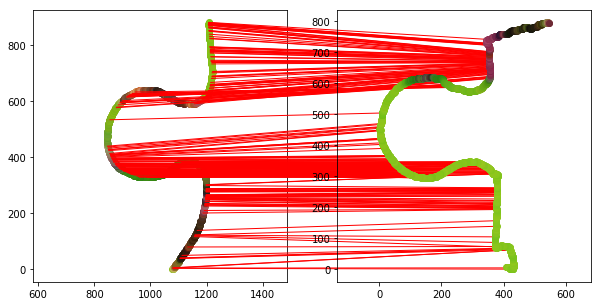

In [165]:
fig = pyplot.figure(figsize=(10, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

xmax1, ymax1 = np.max(c1, axis=0)
xmax2, ymax2 = np.max(c2, axis=0)

for (x, y) in c1:
    y = ymax1 - y
    # x - 10
    ax1.plot(x, y, 'o', color=to_plot_color(p1.image[y, x, [2, 1, 0]]))
ax1.axis('equal')
    
for (x, y) in c2:
#     y = ymax2 - y
    x = xmax2 - x
    # y - 10
    ax2.plot(y, x, 'o', color=to_plot_color(p2.image[y, x, [2, 1, 0]]))
ax2.axis('equal')



for (i, j) in correspondence:
    xy2 = c1[i, 0], ymax1 - c1[i, 1]
    xy1 = c2[j, 1], xmax2 - c2[j, 0]
#     xy1 = c2[j, 1], c2[j, 0]
    con = ConnectionPatch(xyA=xy1, xyB=xy2, coordsA="data", coordsB="data",
                          axesA=ax2, axesB=ax1, color="red")
    ax2.add_artist(con)
    
pyplot.show()


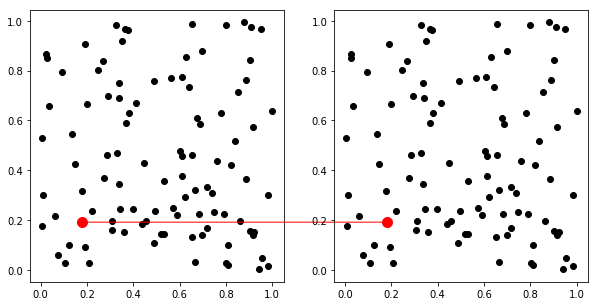

In [37]:
# Example drawing lines across two plots
# taken from: https://stackoverflow.com/questions/17543359/drawing-lines-between-two-plots-in-matplotlib
fig = pyplot.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

x,y = np.random.rand(100),np.random.rand(100)

ax1.plot(x,y,'ko')
ax2.plot(x,y,'ko')

i = 10
xy = (x[i],y[i])
con = ConnectionPatch(xyA=xy, xyB=xy, coordsA="data", coordsB="data",
                      axesA=ax2, axesB=ax1, color="red")
ax2.add_artist(con)

ax1.plot(x[i],y[i],'ro',markersize=10)
ax2.plot(x[i],y[i],'ro',markersize=10)


pyplot.show()

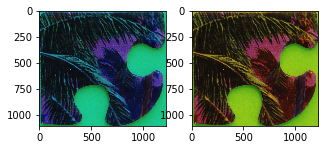

In [78]:
t = p1.image.copy()
t2 = t[:, :, [2, 1, 0]]
pyplot.figure(figsize=(5, 10))
pyplot.subplot(121)
pyplot.imshow(t)
pyplot.subplot(122)
pyplot.imshow(t2)